In [79]:
from ipynb.fs.full.preprocessing_text import PreprocessTweet
from ipynb.fs.full.dict_lexicons import read_lexicon
from ipynb.fs.full.lexicon_mapping import LexiconMapper, Analyzer
from ipynb.fs.full.bert_helper import create_raw_input, pull_bert, get_max_lengths, bert_encode
import pandas as pd

In [80]:
df_140 = pd.read_csv("D:\\Marko\\MoviesSentimentAnalysis\\140SentimentDataset\\training.1600000.processed.noemoticon.csv", 
           names = [
                    'target',
                    'id',
                    'date',
                    'flag',
                    'user',
                    'text'
                ])
df_140.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [81]:
df_crowdflower = pd.read_csv("D:\\Marko\\Project_NLP_171161\\text_emotion.csv", 
        names = [
                'tweet_id',
                'label',
                'user',
                'text'
                ],
           header=0)

df_crowdflower.head()

,tweet_id,label,user,text
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [82]:
vad_lexicon = read_lexicon('NRC-VAD')
afinn_lexicon = read_lexicon('AFINN-111')
nrc_lexicon = read_lexicon('NRC-AffectIntensity')
print(list(vad_lexicon.items())[:5])
print(list(afinn_lexicon.items())[:5])
print(list(nrc_lexicon.items())[:5])

[('aaaaaaah', ['0.479', '0.606', '0.291']), ('aaaah', ['0.520', '0.636', '0.282']), ('aardvark', ['0.427', '0.490', '0.437']), ('aback', ['0.385', '0.407', '0.288']), ('abacus', ['0.510', '0.276', '0.485'])]
[('abandoned', ['-2']), ('abandons', ['-2']), ('abducted', ['-2']), ('abduction', ['-2']), ('abductions', ['-2'])]
[('term', ['score', 'AffectDimension']), ('outraged', ['0.964', 'anger']), ('brutality', ['0.922', 'fear']), ('hatred', ['0.641', 'sadness']), ('hateful', ['0.575', 'sadness'])]


In [83]:
xy140_df = pd.DataFrame(df_140.values[:,0:6:5], columns=['label', 'text'])
xy140_df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [84]:
xycf_df = pd.DataFrame(df_crowdflower.values[:,1:4:2], columns=['label', 'text'])
xycf_df.head()

,label,text
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [85]:
preprocessor = PreprocessTweet()
preprocessed140_df = preprocessor.preprocess_tweets(xy140_df, True, True, False)
preprocessed140_df.head()

,Label,Tweet,Mark,Caps,Letters
0,0,usertag linktag awww thats a bummer you should...,False,False,False
1,0,is upset that he cant update his facebook by t...,False,False,False
2,0,usertag i dived many times for the ball manage...,False,False,False
3,0,my whole body feels itchy and like its on fire,False,False,False
4,0,usertag no its not behaving at all im mad why ...,False,False,False


In [86]:
preprocessedcf_df = preprocessor.preprocess_tweets(xycf_df, True, True, False)
preprocessedcf_df.head()

,Label,Tweet,Mark,Caps,Letters
0,empty,usertag i know i was listenin to bad habit ear...,False,False,False
1,sadness,layin n bed with a headache ughhhh waitin on y...,False,False,True
2,sadness,funeral ceremony gloomy friday,False,False,True
3,enthusiasm,wants to hang out with friends soon,False,False,False
4,neutral,usertag we want to trade with someone who has ...,False,False,False


In [96]:
words_cf = []

for sent in preprocessedcf_df.Tweet:
    words = sent.split()
    for i in range(0, len(words)-2):
        ph = words[i] + " " + words [i+1] + " " + words [i+2]
        words_cf.append(ph)
print(len(words_cf))
print(len(set(words_cf)))
set_cf = set(words_cf)
#print(set_cf)
#print("thats" in set_cf)

443163
346435


In [97]:
contains_cf = []
for sent in preprocessed140_df.Tweet:
    words = sent.split()
    found = [words[i] + " " + words[i+1] for i in range(0, len(words)-2) if words[i] + " " + words[i+1] + " " + words[i+2] in set_cf]
    #print(found)
    contains_cf.append(len(found))
preprocessed140_df['crowdflower'] = contains_cf
preprocessed140_df.head()

,Label,Tweet,Mark,Caps,Letters,crowdflower,onwlen
0,0,usertag linktag awww thats a bummer you should...,False,False,False,4,18
1,0,is upset that he cant update his facebook by t...,False,False,False,3,21
2,0,usertag i dived many times for the ball manage...,False,False,False,2,18
3,0,my whole body feels itchy and like its on fire,False,False,False,2,10
4,0,usertag no its not behaving at all im mad why ...,False,False,False,9,21


In [98]:
preprocessed140_df['onwlen'] = [len(i.split()) for i in preprocessed140_df.values[:,1]]
preprocessed140_df.head()

,Label,Tweet,Mark,Caps,Letters,crowdflower,onwlen
0,0,usertag linktag awww thats a bummer you should...,False,False,False,4,18
1,0,is upset that he cant update his facebook by t...,False,False,False,3,21
2,0,usertag i dived many times for the ball manage...,False,False,False,2,18
3,0,my whole body feels itchy and like its on fire,False,False,False,2,10
4,0,usertag no its not behaving at all im mad why ...,False,False,False,9,21


In [140]:
#preprocessed140_df = 
newpp = preprocessed140_df[preprocessed140_df.crowdflower == preprocessed140_df.onwlen - 6][preprocessed140_df.crowdflower > 1]
#print(preprocessed140_df.shape)
#print(preprocessed140_df.shape)
#preprocessed140_df.head()

<ipython-input-140-0022a4b7fbd8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  newpp = preprocessed140_df[preprocessed140_df.crowdflower == preprocessed140_df.onwlen - 6][preprocessed140_df.crowdflower > 1]


<BarContainer object of 21 artists>

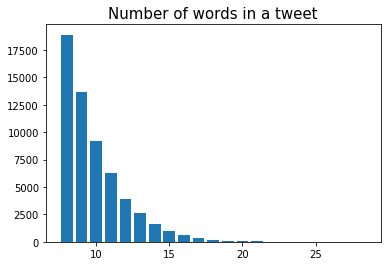

In [141]:
analyzer = Analyzer()
newpp['mapped'] = [i.split() for i in newpp.Tweet.values]
lens = analyzer.get_length_statistics(newpp)
import matplotlib.pyplot as plt

plt.title("Number of words in a tweet", size=15)
plt.bar([k for k in lens.keys()], lens.values())

In [142]:
mapper = LexiconMapper()

lens = [len(i) for i in newpp.mapped]
newpp['lens'] = lens
def get_even_distribution(df, attr, min_sample_size):
    
    low_df = mapper.get_sample(df, df[attr], 0, min_sample_size)
    high_df = mapper.get_sample(df, df[attr], 4, min_sample_size)
    
    distr_df = pd.concat([low_df, high_df])
    return distr_df

valence_df = get_even_distribution(newpp, 'Label', 25000)

print(valence_df.shape)
valence_df.head()

(50000, 9)


,Label,Tweet,Mark,Caps,Letters,crowdflower,onwlen,mapped,lens
674752,0,usertag i need you nick come to brasilia,False,False,False,2,8,"[usertag, i, need, you, nick, come, to, brasilia]",8
428144,0,im going to miss the french open final due to ...,False,False,False,5,11,"[im, going, to, miss, the, french, open, final...",11
721747,0,usertag i was supposed to but i had commitment...,False,True,False,12,18,"[usertag, i, was, supposed, to, but, i, had, c...",18
295952,0,usertag awww i sad i reply to you but i know w...,False,True,False,8,14,"[usertag, awww, i, sad, i, reply, to, you, but...",14
94794,0,usertag o noooooooooo dont say that i dont wan...,False,False,False,4,10,"[usertag, o, noooooooooo, dont, say, that, i, ...",10


<BarContainer object of 20 artists>

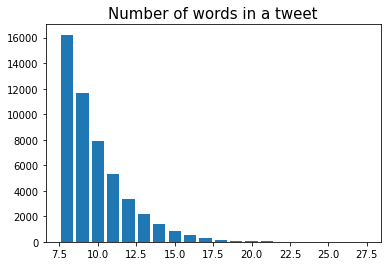

In [143]:
valence_df['mapped'] = [i.split() for i in valence_df.Tweet.values]
lens = analyzer.get_length_statistics(valence_df)
import matplotlib.pyplot as plt

plt.title("Number of words in a tweet", size=15)
plt.bar([k for k in lens.keys()], lens.values())

In [144]:
def init_transfered_model(df, attr):
    x_train, x_test, y_train, y_test = create_raw_input(df['Tweet'], df[attr], 0.25)
    bert_layer, tokenizer = pull_bert('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2')
    #max_seq_len = get_max_lengths(df['Tweet'], tokenizer)
    
    return x_train, x_test, y_train, y_test, bert_layer, tokenizer

x_train, x_test, y_train, y_test, bert_layer, tokenizer = init_transfered_model(valence_df, 'Label')

In [145]:
X_train = bert_encode(x_train, tokenizer, 70)
X_test = bert_encode(x_test, tokenizer, 70)
print(X_train)

{'input_word_ids': <tf.Tensor: shape=(37500, 70), dtype=int32, numpy=
array([[  101,  2026,  2677, ...,     0,     0,     0],
       [  101,  5310, 15900, ...,     0,     0,     0],
       [  101,  2498,  6343, ...,     0,     0,     0],
       ...,
       [  101,  2758,  2031, ...,     0,     0,     0],
       [  101,  1045,  7771, ...,     0,     0,     0],
       [  101,  5310, 15900, ...,     0,     0,     0]])>, 'input_mask': <tf.Tensor: shape=(37500, 70), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>, 'input_type_ids': <tf.Tensor: shape=(37500, 70), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])>}


In [146]:
print(X_train['input_word_ids'][6])

tf.Tensor(
[ 101 1045 2572 3666 6285 1998 5736 4606 1022 1045 2514 2061 2919 2005
 2068  102    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0], shape=(70,), dtype=int32)


In [152]:
import tensorflow as tf

def create_model(bert_layer, max_seq_len, num_class):

    input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name="input_type_ids")

    bert_input = {
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    }

    outputs = bert_layer(bert_input)

    pooled_output = outputs['pooled_output']
    sequence_output = outputs['sequence_output']

    print(pooled_output)

    output = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(sequence_output)
    output = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.MaxPool1D(pool_size=2)(output)
    output = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu')(output)
    output = tf.keras.layers.Flatten()(output)
    output = tf.keras.layers.Dense(num_class, activation='softmax')(output)
    
    model = tf.keras.Model(
        inputs={
            'input_word_ids': input_word_ids,
            'input_mask': input_mask,
            'input_type_ids': input_type_ids
        },
        outputs=output
    )

    model.summary()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics='accuracy'
    )
    
    return model

model_valence = create_model(bert_layer, 70, len(y_train[0]))
model_valence.layers[3].trainable = True
model_valence.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
        loss='categorical_crossentropy',
        metrics='accuracy'
)
print(model_valence.layers[3].trainable)

KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='keras_layer_3/StatefulPartitionedCall:3', description="created by layer 'keras_layer_3'")
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask (InputLayer)         [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_word_ids (InputLayer)     [(None, 70)]         0                                            
__________________________________________________________________________________________________
keras_layer_3

In [153]:
history_valence = model_valence.fit(
    X_train,
    y_train,
    epochs=2,
    verbose=1
)

Epoch 1/2
1172/1172 [==============================] - 1209s 1s/step - loss: 0.4379 - accuracy: 0.7959
Epoch 2/2
1172/1172 [==============================] - 1208s 1s/step - loss: 0.3884 - accuracy: 0.8257


In [154]:
model_valence.evaluate(X_test, y_test)

391/391 [==============================] - 105s 265ms/step - loss: 0.4038 - accuracy: 0.8215


[0.4038226306438446, 0.8215199708938599]

In [155]:
model_valence.save('D:/val_model/valence_model')

INFO:tensorflow:Assets written to: D:/val_model/valence_model\assets


INFO:tensorflow:Assets written to: D:/val_model/valence_model\assets


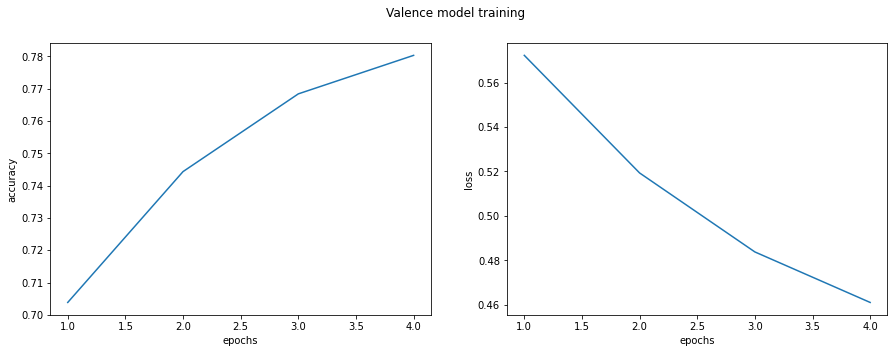

In [22]:
# previous model
import matplotlib.pyplot as plt

def show_results(history, subtitle):
    metrics_data = [history.history['accuracy'], history.history['loss']]
    labels = ['accuracy', 'loss']
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    fig.suptitle(subtitle)

    for data, ax, label in zip(metrics_data, axes, labels):
        ax.set_xlabel('epochs')
        ax.set_ylabel(label)
        ax.plot(range(1,2), data)

    plt.show()
    
show_results(history_valence, "Valence model training")

In [23]:
#previous model
model_valence.save('D:/model_valence_78/valence_model')

INFO:tensorflow:Assets written to: D:/model_valence_78/valence_model\assets


INFO:tensorflow:Assets written to: D:/model_valence_78/valence_model\assets


In [24]:
#previous model
from collections import Counter

df_mark = valence_df[valence_df.Mark == True]
df_mark.head()
print(Counter(df_mark.Label))

df_caps = valence_df[valence_df.Caps == True]
df_caps.head()
print(Counter(df_caps.Label))

df_letters = valence_df[valence_df.Letters == True]
df_letters.head()
print(Counter(df_letters.Label))

Counter({4: 8894, 0: 5851})
Counter({0: 8050, 4: 6681})
Counter({0: 6701, 4: 6108})
